# **Assignment 8**
# **Flares – temporal evolution and magnetic field structure. Part II.**

### **Data Analysis for Space Weather | Instructor: Prof Podladchikova | April, 2021**
### **by Victoria Krivova, Polina Starodumova**

Analysis of an X-class flare, observed with the Atmospheric Imaging Assembly (AIA) onboard
NASA’s SDO satellite in the UV wavelengths domain at 1700 Å, the HMI instrument onboard
SDO (continuum and magnetic field maps) as well as the full-disk integrated soft X-ray flux by
the GOES satellite. The flare occurred on 2014 October 24, with start time around ~21 UT.

In [317]:
# importing necessary libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import math
import imageio
from matplotlib.colors import LogNorm
from PIL import Image
import warnings
import scipy
import sunpy
import sunpy.map
from astropy.io import fits
from astropy import units as u
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import stats

**First we'll look at the GOES soft X-ray flux in the 1–8 Å wavelength band data and plot the data as function of time (in min), where y axis is in logarithmic scale. Data contains time (in sec) since start
time 24-Oct-2014 21:00:00 and the corresponding 1–8 Å soft X-ray flux (in Wm−2).**

In [324]:
flux = pd.read_csv('goes.txt', header=None, delim_whitespace=True)

flux.columns = ['time', 'value']
flux.time = pd.to_numeric(flux.time)
flux.value = pd.to_numeric(flux.value)

flux['time_min'] = flux.time / 60 # converting to minutes
flux['log_value'] = np.log(flux.value) # natural log scale
flux['value_corr'] = flux.value * 10**4 # convenient form

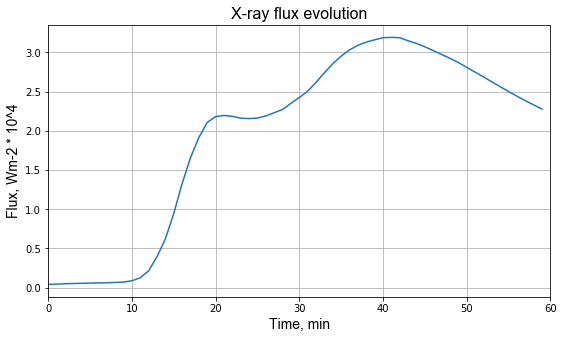

In [322]:
axis_font = {'fontname':'Arial', 'size':'14'}
title_font = {'fontname':'Arial', 'size':'16'} 

plt.figure(figsize=(9, 5))
plt.plot(flux.time_min, flux.value_corr)
plt.xlabel('Time, min', **axis_font)
plt.ylabel('Flux, Wm-2 * 10^4', **axis_font)
plt.title('X-ray flux evolution', **title_font)
plt.xlim(0, 60)
plt.grid(True)

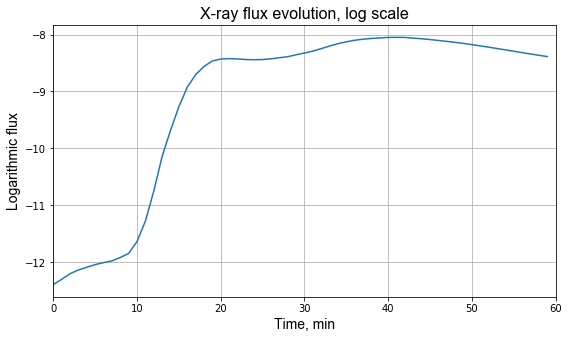

In [323]:
plt.figure(figsize=(9, 5))
plt.plot(flux.time_min, flux.log_value)
plt.xlabel('Time, min', **axis_font)
plt.ylabel('Logarithmic flux', **axis_font)
plt.xlim(0, 60)
plt.title('X-ray flux evolution, log scale', **title_font)
plt.grid(True)

In [6]:
flux.value.max()

0.00031919

**In assignment we work with the flux in time of solar flare which is usually accompanied by radio and X-ray bursts. The maximum of the flux curve is 0.0003 Wm-2. According to GOES X-ray flare classification, an X-class flare has a peak 1–8 Å flux above 0.0001 Wm-2. Thus we can describe the flare on 24 Oct 2014 as X-class.**

**Next let's calculate the time derivative of the GOES 1–8 Å light curve:**

In [152]:
time_deriv = np.gradient(flux.value)

And recall from the previous assignemnt area of flare as a function of time:

In [285]:
files = [sunpy.io.fits.read('AIA_1700_%02d.fits' % i)[0] for i in range(49)]
data = [files[i].data for i in range(49)]
header = [files[i].header for i in range(49)]

a = 590
b = 850
c = 1100
d = 1450

th = 4500

def bin_mask(flare):
    mask = np.empty(shape=[b-a, d-c])
    for k in range (0, b-a):
        for j in range (0, d-c):
            if (flare[k][j]) >= th:
                mask[k][j] = 1
            else:
                mask[k][j] = 0
    return mask

def flare_pix(mask_filt):
    flare_pix = 0
    for k in range (0, b-a):
        for j in range (0, d-c):
            if mask_filt[k][j] == 1:
                flare_pix += 1
    return flare_pix

resol_1 = header[12]['CDELT1'] # arcsec/pix
resol_2 = header[12]['CDELT2']
arcsec_sun = header[12]['RSUN_OBS'] # radius of Sun in arcseconds

R_sun = 696340 # km
km_per_arcsec = R_sun / arcsec_sun     

area_unit = (resol_1 * km_per_arcsec) * (resol_2 * km_per_arcsec) # km^2

squares = []

for i in range(49):
    flare_i = data[i][a:b, c:d] # subfield
    mask_filt_i = scipy.ndimage.median_filter(bin_mask(flare_i), size=5, mode='reflect')
    flare_sq = flare_pix(mask_filt_i) * area_unit
    squares.append(flare_sq)    
    
squares = np.array(squares)

times = []

for i in range(49):
    times.append(header[i]['DATE-OBS'])

times = pd.Series(times)
times_m = pd.to_datetime(times).dt.minute
times_s = pd.to_datetime(times).dt.second

In [325]:
times_minute = (times_m * 60 + times_s) / 60 

Now let's plot:  
a) the time derivative of the GOES 1–8 Å light curve as function of time  
b) the flare area A(t) determined from the AIA data as function of time

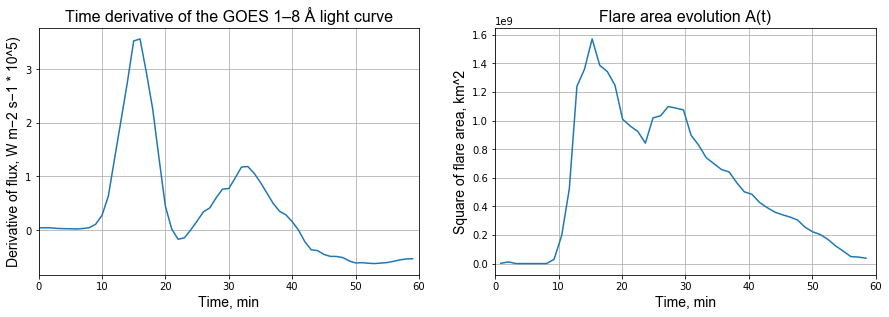

In [287]:
fig = plt.figure(figsize=(15, 10))

ax2 = fig.add_subplot(2,2,1)
plt.plot(flux.time_min, time_deriv*10**5)
ax2.set_xlabel('Time, min', **axis_font)
ax2.set_ylabel('Derivative of flux, W m−2 s−1 * 10^5)', **axis_font)
ax2.set_title('Time derivative of the GOES 1–8 Å light curve', **title_font)
ax2.set_xlim(0, 60)
ax2.grid()

ax1 = fig.add_subplot(2,2,2)
plt.plot(times_minute, squares)
ax1.set_xlabel('Time, min', **axis_font)
ax1.set_ylabel('Square of flare area, km^2', **axis_font)
ax1.set_xlim(0, 60)
ax1.set_title('Flare area evolution A(t)', **title_font)
ax1.grid()

**Obviously, there's some similarity in curves' behaviour: both of them have two distinctive peaks – and first ones happen at about 15th second since the start time (21:00).**

**Next we'll interpolate the flare area A(t) determined from AIA data, so that they are given for the
same time steps as the GOES 1–8 Å fluxes (every minute from 21 to 22 pm).**

In [288]:
f = interpolate.interp1d(times_minute, squares, fill_value="extrapolate")
time_intrpld = flux.time_min
squares_intrpld = f(time_intrpld) 

**Let's create a scatter plot of the GOES 1–8 Å time derivative against the corresponding AIA flare areas:**

Text(0.5, 1.0, 'Scatter plot of GOES data time derivative against the AIA flare areas')

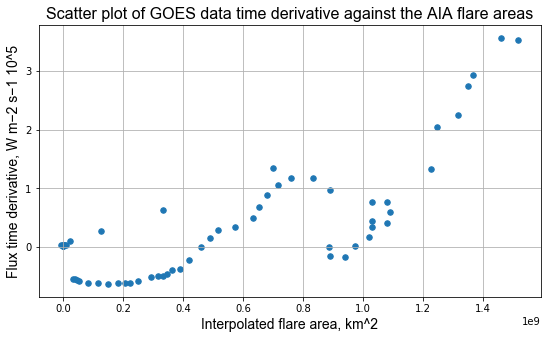

In [345]:
plt.figure(figsize=(9,5))
plt.scatter(squares_intrpld, time_deriv*10**5, s=30)
plt.grid(True)
plt.xlabel('Interpolated flare area, km^2', **axis_font)
plt.ylabel('Flux time derivative, W m−2 s−1 10^5', **axis_font)
plt.title('Scatter plot of GOES data time derivative against the AIA flare areas', **title_font)

**Let's make a linear fit to the data and overplot it:**

In [347]:
from sklearn.linear_model import LinearRegression

x = np.array(squares_intrpld).reshape(-1, 1)
y = time_deriv*10**5
model = LinearRegression().fit(x, y)

intercept = model.intercept_
slope = model.coef_

a = slope
b = intercept

y_fit = a * squares_intrpld + b

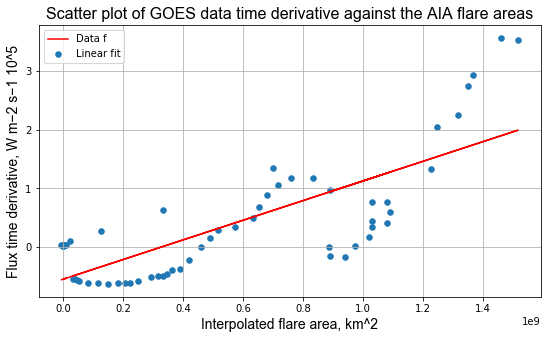

In [348]:
plt.figure(figsize=(9,5))
plt.scatter(squares_intrpld, time_deriv*10**5, s=30)
plt.plot(squares_intrpld, y_fit, color='red')
plt.grid(True)
plt.xlabel('Interpolated flare area, km^2', **axis_font)
plt.ylabel('Flux time derivative, W m−2 s−1 10^5', **axis_font)
plt.title('Scatter plot of GOES data time derivative against the AIA flare areas', **title_font)
plt.legend(['Data f', 'Linear fit'])

**Using the whole dataset for linear fit we obtain too many outliers. For calculating correlation coefficient we'll consider part of curve there is direct relation (up to the point ~(0.8, 1.2)). As seen from plots above, it corresponds the declining part of the curves after the second peak.**

In [290]:
print('Pearson correlation coefficient between the two data sets is {:.1f}'.format(scipy.stats.pearsonr(squares_intrpld[30:], time_deriv[30:])[0]))

Pearson correlation coefficient between the two data sets is 0.9


**Correlation is large enough in this part so we can make a conclusion that with flare area decrease, the growth of flux value firstly slows down and then flux starts to decrease. We've fixed the mask filtration in AIA data in some degree, but algorithm still underestimates the flare area and true relations can be a little different. The issue is that lowering the threshold leads to detecting bigger noise spots which are not dismissed with mild filtering.**

**Next from the flare pixel mask sequence let's create a mask which contains all pixels that have been identified as flare pixels over the whole observation interval. To reduce noise in the binary image median filtration is applied.**

In [291]:
mask_array = []

for i in range(49):
    flare_i = data[i][a:b, c:d] 
    mask_array.append(scipy.ndimage.median_filter(bin_mask(flare_i), size=3, mode='reflect'))

In [299]:
total_pixel_mask = np.empty(shape=[b-a, d-c])
for i in range(49):
    for k in range (0, b-a):
        for j in range (0, d-c):
            if mask_array[i][k][j] == 1:
                total_pixel_mask[k][j] = 1

# fill empty pixel values
for k in range (0, b-a):
    for j in range (0, d-c):                
        if total_pixel_mask[k][j] != 1:
            total_pixel_mask[k][j] = 0

Text(0.5, 1.0, 'Total flare area pixel mask')

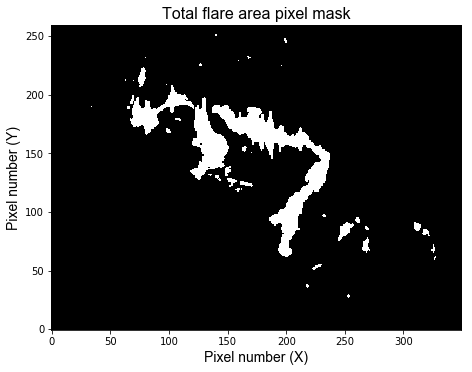

In [293]:
fig = plt.figure(figsize=(25, 15))

ax1 = fig.add_subplot(2,3,1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(total_pixel_mask, cmap='Greys_r')
ax1.invert_yaxis()
ax1.set_title('Total flare area pixel mask', **title_font)

**Let's calculate how much the total flare area is:**

In [294]:
flare_sq = flare_pix(total_pixel_mask) * area_unit  
print('Total flare area is {} km^2'.format(round(flare_sq)))

Total flare area is 4026031274 km^2


In [295]:
print('Area has its maximum at', times[squares.argmax()])
print('Image index is', squares.argmax())

Area has its maximum at 2014-10-24T21:15:18.74
Image index is 12


**Let's look at co-aligned HMI/SDO line-of-sight vector magnetogram and continuum images that have been recorded at the time of the flare start (21:00).**

In [296]:
ANG = u.def_unit('ANG', 10**(-10) * u.m)
u.add_enabled_units([ANG]);

data_1, header_1 = sunpy.io.fits.read('HMI_continuum.fits')[0]
map_1 = sunpy.map.Map(data_1, header_1)

data_2, header_2 = sunpy.io.fits.read('HMI_magnetogram.fits')[0]
map_2 = sunpy.map.Map(data_2, header_2)

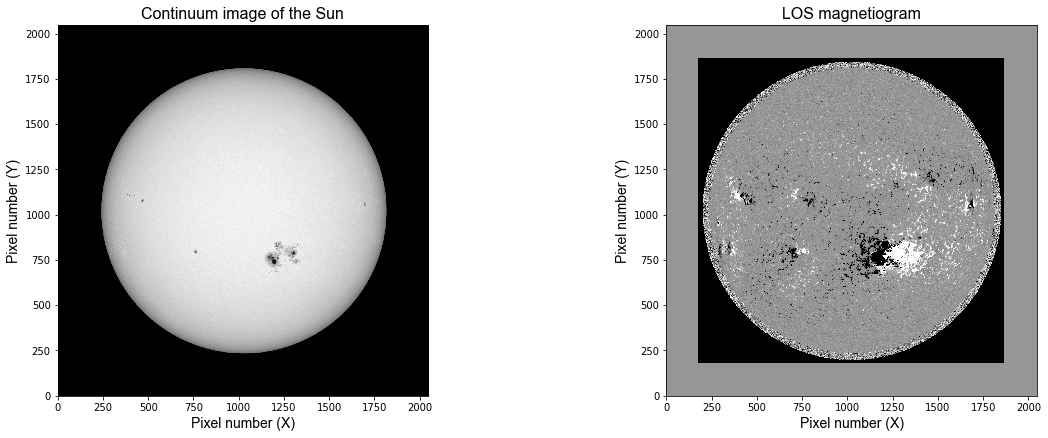

In [297]:
fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(data_1, cmap='Greys_r', norm=colors.Normalize(vmin=0, vmax=64000))
ax1.invert_yaxis()
ax1.set_title('Continuum image of the Sun', **title_font)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(data_2, cmap='Greys_r', norm=colors.Normalize(vmin=-100, vmax=100))
ax2.invert_yaxis()
ax2.set_title('LOS magnetiogram', **title_font);

**Now let's create a plot of the corresponding subfields with flare area side by side: AIA 1700 (at time of flare maximum – 21:15), HMI continuum, HMI magnetogram and overplot the contours of the total flare pixel mask on all three images:**

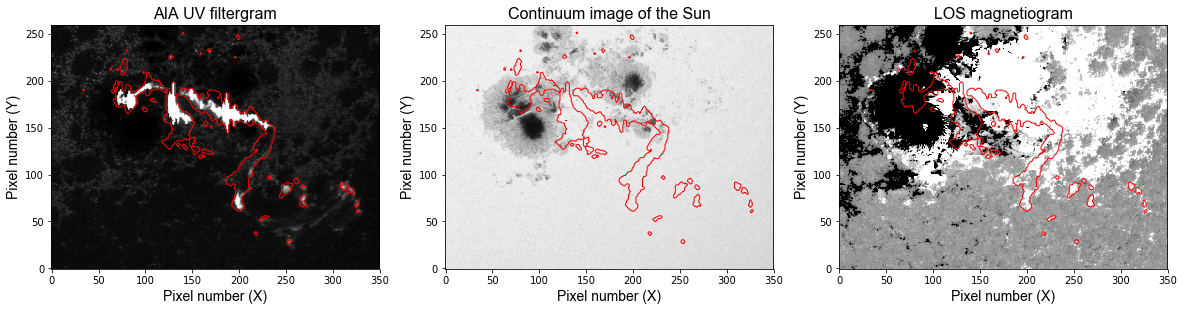

In [298]:
fig = plt.figure(figsize=(20, 15))

ax3 = fig.add_subplot(2,3,1)
ax3.set_xlabel('Pixel number (X)', **axis_font)
ax3.set_ylabel('Pixel number (Y)',  **axis_font)
ax3.imshow(data[12][a : b, c:d], cmap='Greys_r')
ax3.invert_yaxis()
plt.contour(total_pixel_mask, colors = 'red', alpha=1, levels=(0,1), linewidths = 1)
ax3.set_title('AIA UV filtergram', **title_font)

ax1 = fig.add_subplot(2,3,2)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(data_1[a : b , c:d], cmap='Greys_r', norm=colors.Normalize(vmin=0, vmax=64000))
ax1.invert_yaxis()
plt.contour(total_pixel_mask, colors = 'red', alpha=1, levels=(0,1), linewidths = 1)
ax1.set_title('Continuum image of the Sun', **title_font)

ax2 = fig.add_subplot(2,3,3)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(data_2[a : b, c:d], cmap='Greys_r', norm=colors.Normalize(vmin=-100, vmax=100))
ax2.invert_yaxis()
plt.contour(total_pixel_mask, colors = 'red', alpha=1, levels=(0,1), linewidths = 1)
ax2.set_title('LOS magnetiogram', **title_font);

**Using the total flare pixel mask let's calculate the magnetic flux underlying the flare ribbons, separately for the positive and negative polarity. That will allow us to estimate which regions on the Sun were involved in a flare magnetic reconnection process.**

In [308]:
pos_pix_sum = 0
neg_pix_sum = 0

subset = data_2[a : b, c:d]
for k in range (0, b-a):
    for j in range (0, d-c):                
        if total_pixel_mask[k][j] == 1:
            if subset[k][j] >= 0:
                pos_pix_sum += subset[k][j]
            else:
                neg_pix_sum += subset[k][j]

In [312]:
cm_per_arc = R_sun / arcsec_sun * 100000  # сm/arcsec  - convertion of the arcseconds to the centimeters
cm_per_pix = cm_per_arc * resol_1       # cm/pix     - linear resolution of the pixel in centimeters

positive_flux = pos_pix_sum * cm_per_pix ** 2
negative_flux = neg_pix_sum * cm_per_pix ** 2

In [316]:
print("The total magnetic flux of flare area with positive polarity is %.2e" % positive_flux, 'Maxwells.')
print("The total magnetic flux of flare area with positive polarity is %.2e" % negative_flux, 'Maxwells.')

The total magnetic flux of flare area with positive polarity is 8.12e+21 Maxwells.
The total magnetic flux of flare area with positive polarity is -7.04e+21 Maxwells.


**Positive and negative polarity areas have relatively similar flux, what is expected from magnetic reconnection – process when the magnetic field topology is rearranged and magnetic energy is converted to kinetic, thermal one or particles acceleration. Actually, absolute values of flux should be bigger as flare area from AIA data is underestimated but the order of the numbers is obtained properly.**

**Learning log:**

In this assignment we've continued to work with X-class flare on 24 Oct 2014 by analysing data of AIA UV 1700 Å, HMI magnetograms and GOES X-ray flux 1–8 Å data. We've found interesting similarity in numbers of flare area and x-ray flux and their evolution with time. Using total flare area pixel mask, which defines area flare covers during its lifetime, we've obtained its location in relation to sunspots and active regions. As a result, we've estimated correctly the total flux underlying the flare ribbons both for positive and negative polarity. Their compatibility confirms theory of magnetic reconnection and helps in developing proper flare models, confined and eruptive.